CORD-19 Dataset

Amaç: Bilimsel makalelerin özetlerinden yola çıkarak, bu makalelerin aşı ("vaccine") konusuyla ilgili olup olmadığını belirlemek ve model eğitmektir.

In [1]:
import pandas as pd

df = pd.read_csv("/Users/admin/StudioProjects/kizbasina-ds-bootcamp/CORD-19/data/metadata.csv", low_memory=False)
print(df.head())

   cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc

cord_uid - Her makale için benzersiz bir ID.
sha - Makale PDF’lerinin hash ID’si (dosya eşleştirme için).
source_x - Veri kaynağı (PMC, Elsevier vb.).
title - Makalenin başlığı.
doi - Makalenin DOI numarası (dijital tanımlayıcı).
pmcid, pubmed_id - Makalenin PubMed ve PMC kimlikleri.
license - Kullanım lisansı

In [2]:
df[['title', 'abstract']].head(5)

,title,abstract
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...


In [3]:
# Eksik veri sayısı
print(df.isnull().sum())

# Yayın tarihini datetime'a çevir
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

cord_uid                  0
sha                  682894
source_x                  0
title                   503
doi                  399880
pmcid                667089
pubmed_id            557728
license                   0
abstract             235544
publish_time           1814
authors               23869
journal               87322
mag_id              1056660
who_covidence_id     573725
arxiv_id            1042411
pdf_json_files       682894
pmc_json_files       740918
url                  369726
s2_id                 80192
dtype: int64


In [4]:
#Sadece özeti ve başlığı olanları al
df = df[df['abstract'].notnull() & df['title'].notnull()]

In [5]:
#vaccine geçen özetleri seç
vaccine_df = df[df['abstract'].str.contains("vaccine", case=False, na=False)]

/var/folders/j6/qz7jvdw95wx8s6pcwts1vqj00000gn/T/ipykernel_8397/2348601215.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccine_df['year'] = vaccine_df['publish_time'].dt.year


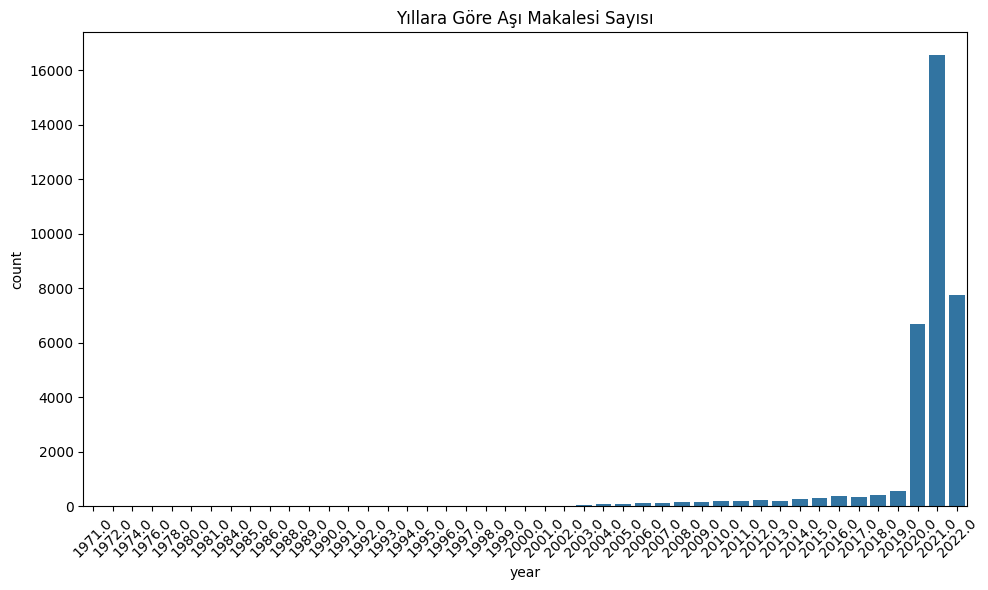

In [6]:
#yıllara göre dağılım
import matplotlib.pyplot as plt
import seaborn as sns

vaccine_df['year'] = vaccine_df['publish_time'].dt.year
plt.figure(figsize=(10,6))
sns.countplot(data=vaccine_df, x='year', order=sorted(vaccine_df['year'].dropna().unique()))
plt.title("Yıllara Göre Aşı Makalesi Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

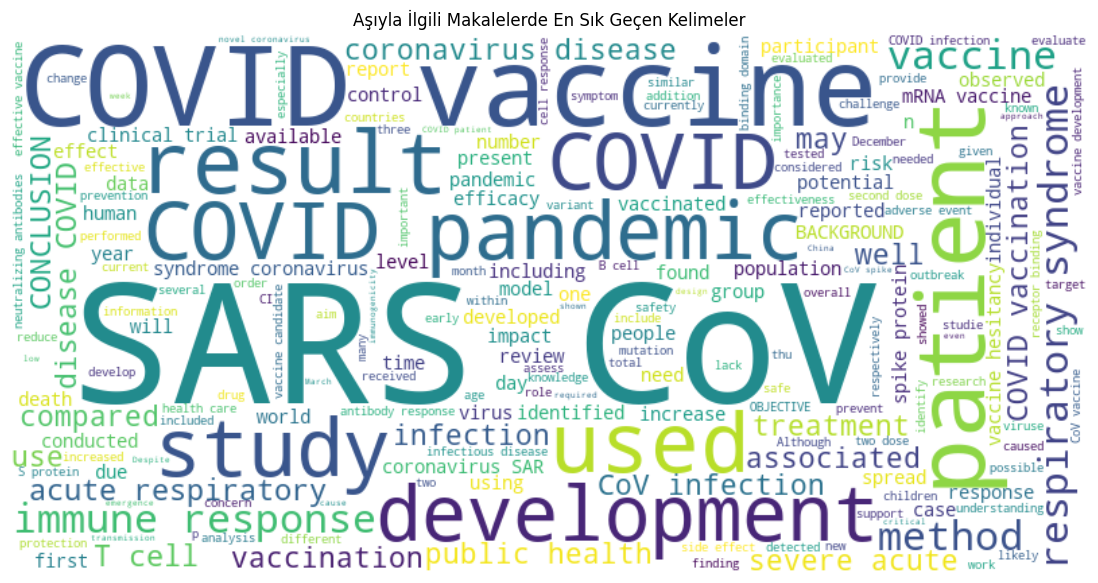

In [7]:
from wordcloud import WordCloud

text = " ".join(abstract for abstract in vaccine_df['abstract'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Aşıyla İlgili Makalelerde En Sık Geçen Kelimeler")
plt.show()

Sınıflandırma Modeli

In [8]:
#"vaccine" geçiyorsa 1, yoksa 0
df['label'] = df['abstract'].str.contains("vaccine", case=False, na=False).astype(int)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Sadece abstract ve label kullanalım
X = df['abstract']
y = df['label']

# Eğitim ve test verisi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vektörleştirici
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Model Eğitimi

In [10]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Bir model nesnesi oluşturur, eğitim verisiyle (X_train_vec, y_train) modeli eğitir.

In [11]:
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    151915
           1       1.00      0.94      0.97     12286

    accuracy                           1.00    164201
   macro avg       1.00      0.97      0.98    164201
weighted avg       1.00      1.00      1.00    164201



Test verisini kullanarak modelin tahminini yapar. Gerçek etiketlerle karşılaştırarak başarıyı ölçer:
Precision, Recall, F1-score, Accuracy.

Accuracy: Kaç tahmin doğru?
Precision: Model "aşı" dediğinde ne kadar doğru?
Recall: Gerçek aşı metinlerinin ne kadarını doğru buldu?
F1-score: Precision ve recall’un dengesi

Modeli Kaydetme

In [ ]:
import joblib

joblib.dump(model, 'vaccine_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

Eğitilmiş Modeli Test Etme

“EVET” → bu metin aşı ile ilgili.
“HAYIR” → bu metin aşı ile ilgili değil.

In [12]:
sample_text = ["This study investigates the efficacy of COVID-19 vaccines on new variants."]
sample_vec = vectorizer.transform(sample_text)
prediction = model.predict(sample_vec)

print("Aşı ile ilgili mi?:", "EVET" if prediction[0] == 1 else "HAYIR")

Aşı ile ilgili mi?: EVET


Model eğitildikten sonra
➡️ Bir metni (örneğin bir makale özeti) alıp, bu metnin “aşı hakkında mı?” olup olmadığını tahmin edebilen bir modelimiz olmuş olur.